<h3 style=color:#362419> Deep Learning Models </h3>

<p style=color:#38629C>This is second notebook in the Final Project focused on training the LSTM deep learning model. The performance of LSTM will be compare against the Naive Bayes Multinomial, which is the best performing model among traditional techniques.</p>

<h3 style=color:#362419> Long short-term memory (LSTM)</h3>

<p style=color:#38629C>LSTM is being used instead of ANN for classification (fake or real news) because it's based on RNN deep neural network and have capability of learning order dependence in sequence prediction problems. Learning such skills is crucial for tackling challenging issues like automated translation and speech recognition.</p>

<p style=color:#38629C>LSTM is a special kind of RNN that attempts to overcome long-term dependency problems because it remembers the information for quite long period based on relevancy. LSTM also have loop-like structure, but the repeating module is quite different from RNN, which has 4 different types of unique interaction. Comparison between Inner structure of RNN and LSTM is as follows:</p>

<img src="../Assets/LSTM-1.png" alt="Image" width="500" height="200">
<p>Repeating module in standard RNN Module with Single Layer</p>
<img src="../Assets/LSTM-2.png" alt="Image" width="500" height="200">
<p>Repeating module in LSTM with four interactions (Gates)</p>

<p style=color:#38629C><u style=color:#467200>Forget Gate Layer</u> → It’s sigmoid function that takes input from the previous hidden state (ht-1) and current input Xt and output value between 0 and 1 for each element in Xt-1. A value of 1 means " keep this information" and a value of 0 means "get rid of this information."</p>

<p style=color:#38629C><u style=color:#467200> Input Gate Layer</u> → The next step for LSTM is to decide that what new information should be stored in the cell. It is based on two component (1) sigmoid layer that decide which elements/value of the cell needed to be updated and (2) tanh generates a vector of new values that could be added to the cell state.</p>

<p style=color:#38629C><u style=color:#467200> Update the Cell State </u> → This stage involves forget gate layer and the input gate layer working together, which updates the current cell state based on the decision made in the previous steps. It multiplies the old values from the forget gate and adds the product of input gate layer.</p>

<p style=color:#38629C>In summary, this stage performs arithmetic operations on the outputs of forget gate layer and input gate layer to selectively forget irrelevant information from the previous cell state and add new relevant information based on the input and the context.</p>

<p style=color:#38629C><u style=color:#467200>Output Gate Layer</u> → This is final gate determines that what should be provided as output based on the cell state. It also includes a sigmoid function to decide which part of the cell should be provided as output, and a tanh layer to scale the values between 1 and -1. It provides a filtered output by multiplying the sigmoid gate with the scaled cell state. E.g. focusing on the relevant information for the prediction of the next word or class in the NLP.</p>

<h3 style=color:#362419> Importing the Required Libraries</h3>

<p style=color:#38629C>Downloading the required libraries for the LLM training</p>

In [51]:
#Preprocessing and Evaluation libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

#Deep learning libraries
import tensorflow as tf
import keras
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.layers import LSTM, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.models import load_model
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Displaying Libraries
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [2]:
# Checking that GPU is available
gpu = len(tf.config.list_physical_devices('GPU'))>0
gpu

True

<h3 style=color:#362419> Loading datasets and Splitting </h3>

<b style=color:#467200> 1. Loading the dataset </b> <p style=color:#38629C>Cleaned data extracted after preprocessing the text in Notebook-1 is loaded for the purpose of training of deep neural LSTM based model.</p>

In [9]:
cleaned_df = pd.read_csv('../Datasets/cleaned_data.csv')

In [10]:
cleaned_df

,label,title_text
0,true,national federation independent business
1,true,comment fayetteville nc
2,true,romney make pitch hope close deal election roc...
3,true,democratic leader say house democrats united g...
4,true,budget united states government fy
...,...,...
60731,fake,white house theatrics gun control 21st century...
60732,fake,activist terrorist medium control dictate narr...
60733,fake,boiler room surrender retreat head roll ep tun...
60734,fake,federal showdown looms oregon blm abuse local ...


In [11]:
cleaned_df['title_text'] = cleaned_df['title_text'].astype(str)

<b style=color:#467200>2. General OverView - Polarity, News Text Length and Word Count </b> <p style=color:#38629C>Though, the overview of the new text has already perfromed during feature presentation and dataset outlook section. However, This is reproduced here for the reference purposes to identify Vocabulory size and sentence for one-hot encoding and embedding the documents (News Text).</p>

In [12]:
# Checking the polarity (Ranges between -1 and 1) of the title_text based on the sentiment attribute in "TextBlob".
cleaned_df['polarity'] = cleaned_df['title_text'].map(lambda text: TextBlob(text).sentiment.polarity)
cleaned_df['text_length'] = cleaned_df['title_text'].astype(str).apply(len)
cleaned_df['word_count'] = cleaned_df['title_text'].apply(lambda x: len(str(x).split()))

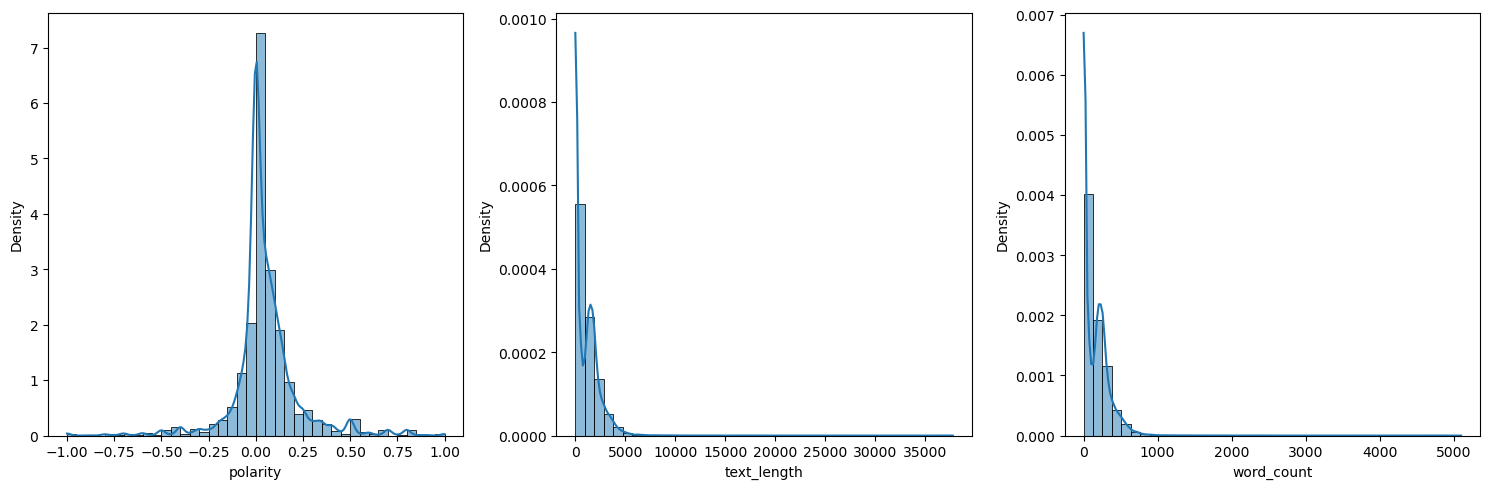

In [13]:
# select the columns to be plotted
cols = ['polarity', 'text_length', 'word_count']

# create the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.histplot(data=cleaned_df[col], kde=True, stat='density', ax=ax, bins=40)

fig.tight_layout()
plt.show()



*   We can notice that most articles has polarity of almost 0 neither being sad nor happy.
*   Text length for the news is around 0-5000 characters.
*   Wrod count is in between 0-1000 words.



<b style=color:#467200>3. One-Hot Encoding </b> <p style=color:#38629C>One-hot encoding in NLP is used to categorize the textual data as dense vectors to be processed by the neural networks. Words in NLP being categorical variables are expensive to process, therefore, one-hot encoding is used to represent these words into dense, continuous vectors (embeddings) by having a binary vector of the same length as vocabulary size.
</p>

In [14]:
#Vocabulary size is set to 7000 words because maximum text length is around 5000 based on text_length plot
voc_size=7000

#One hot encoding using tensor flow keras module to news text into numerical vectors
onehot_repr=[one_hot(words,voc_size)for words in cleaned_df['title_text']]

In [15]:
onehot_repr[0:10]

[[2345, 558, 6176, 1090],
 [1086, 1534, 1109],
 [4173, 6706, 5669, 3681, 4665, 3648, 4561, 3351, 989, 5917],
 [4290, 3446, 6534, 2629, 3422, 3805, 4528, 4890, 22],
 [6232, 3805, 1020, 2931, 3956],
 [2415, 4582, 1537, 6534, 1523, 6338, 3699, 5615, 5708, 2498],
 [6397, 1626],
 [5027, 5968],
 [319, 703, 2629, 6505, 6113, 3761, 2448],
 [6087, 2008, 6815, 5398, 2320]]

<p style=color:#38629C>We can notice that all the text is converted into index for the vocabulary created.</p>


<b style=color:#467200>4. Padding the documents </b> <p style=color:#38629C>The second step in implementation is to perform the padding of documents. Padding of the text is required to have a fixed length of tokens. This is fundamental for the neural network to have inputs for fixed size because textual data could be shorter or longer. Tensor flow Keras pad_sequence is used to perform the padding for neural network and sequence is kept as `pre` to ensure `zero's` is added at the beginning. Benefit of using `pre` are as follows:
*   Preserving the contextual information by keeping words towards the end in order for the model to capture the meaningful context.
*   It provides the compatibility with the right to left languages, such as Arabic or Urdu.
*   It gives the fixed length inputs for the vectors for model to process.
*   It ensures consistency and simplicity for different layers of the models, such as embedding layer and convolution layer.</p>

In [16]:
#Fixed sentence length to be padded or truncated in order to have a length of 5000 tokens.
sent_length=5000

# Padding the sequences of one-hot encoded vectors
# Pre is provided to esnure padding (or truncating) [Zeros] is added to the beginning of each sequence.
# This ensures that the actual content of the sentence is closer to the end
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)



[[   0    0    0 ...  558 6176 1090]
 [   0    0    0 ... 1086 1534 1109]
 [   0    0    0 ... 3351  989 5917]
 ...
 [   0    0    0 ... 1401 6160 6923]
 [   0    0    0 ...  712 6193 2955]
 [   0    0    0 ... 3696 6036 6907]]


<b style=color:#467200>5. Defining Model - Long short-term memory (LSTM) </b> <p style=color:#38629C>Now we can performed the sequential model network for classification of news between `true` or `fake`. This will be achieved using keras with tensor flow backend having below mentioned layers:

1.   Embedding layer having embedding vector features to have a dense vector of 40 [40-Dimentional vector space]. This could be adjusted based on hyperparameter tuning and adopting experimental approach.
2.   First Drop-out  for the regularization to avoid the overfitting, which could be occured by models during the trianing or inference phase.
3.   LSTM layer for the sequence modeling.
4.   Second Drop-out layer for the regularization.
5.   Final Dense Layer with activation function Sigmoid used for the binary classification tasks.

`Input (Word indices) --> Embedding Layer --> Dropout --> LSTM --> Dropout --> Dense (Sigmoid)`</p>

In [17]:
# Number of Dimensions for the word embeddings
embedding_vector_features=40
# Initializing the sequential model
model=Sequential()
# adding the embedding layer
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
# First Dropout layer for the regularization with rate of 0.3
model.add(Dropout(0.3))
#Adding 100 lstm neurons in the layer
model.add(LSTM(100))
# Second Dropout layer for the regularization with rate of 0.3
model.add(Dropout(0.3))
# Fully connected dense layer with activation function 'sigmoid' for binary classifcation.
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

2023-09-15 18:23:53.625773: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-09-15 18:23:53.626303: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-15 18:23:53.626313: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-15 18:23:53.627180: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-15 18:23:53.627760: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 40)          280000    
                                                                 
 dropout (Dropout)           (None, 5000, 40)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 336501 (1.28 MB)
Trainable params: 336501 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
# Embedding are based on the text and label are taken directly from the dataframe (cleaned_df). Both have similar length in numbers.
# For a binary classification task, the shape of cleaned_df['label'] as (60737,), indicating that you have there are 60737 binary labels (0s and 1s).
len(embedded_docs),cleaned_df['label'].shape

(60736, (60736,))

<b style="color:#467200">6. Model Fitting</b>
<p style="color:#38629C">This process involves the following steps:</p>

<ul style="color:#38629C">
  <li>Preparing the data as a Numpy array for model fitting.</li>
  <li>Splitting the dataset into training and testing subsets.</li>
  <li>Defining and setting the batch size for training.</li>
  <li>Performing multiple runs to find the best hyperparameters, including batch size and the optimal number of epochs.</li>
</ul>



In [62]:
# Converting the embedded documents [List of one hot encoded vectors] and labels as array before fitting into the models
X_final=np.array(embedded_docs)
# labels (true and fake) are converted into 0 and 1 before fitting into model as it only expects numerical values
y_final = np.array(cleaned_df['label'].replace({'true': 1, 'fake': 0}))

#Check shape of X [text] and y[label] as final array
X_final.shape,y_final.shape

((60736, 5000), (60736,))

<p style="color:#38629C">Dataset is splitted into X_train, X_test, y_train, y_test using Sk-Learn library with the ratio 80% - Training and 20% Testing.</p>

In [64]:
# Splitting the final data into X_train, X_test, y_train and y_test for model fitting
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


<b style="color:#467200">6a. First Run</b>

<ul style="color:#38629C">
  <li>Number of epochs: 10</li>
  <li>Batch Size: 64</li>
</ul>


In [29]:
# Splitting the final data into X_train, X_test, y_train and y_test for model fitting
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
760/760 [==============================] - 270s 344ms/step - loss: 0.3315 - accuracy: 0.8628 - val_loss: 0.2272 - val_accuracy: 0.9058
Epoch 2/10
760/760 [==============================] - 195s 256ms/step - loss: 0.2185 - accuracy: 0.9101 - val_loss: 0.2465 - val_accuracy: 0.8976
Epoch 3/10
760/760 [==============================] - 174s 229ms/step - loss: 0.1750 - accuracy: 0.9285 - val_loss: 0.2419 - val_accuracy: 0.9037
Epoch 4/10
760/760 [==============================] - 165s 217ms/step - loss: 0.2091 - accuracy: 0.9129 - val_loss: 0.2373 - val_accuracy: 0.9040
Epoch 5/10
760/760 [==============================] - 161s 212ms/step - loss: 0.1601 - accuracy: 0.9354 - val_loss: 0.2454 - val_accuracy: 0.9043
Epoch 6/10
760/760 [==============================] - 162s 213ms/step - loss: 0.1685 - accuracy: 0.9319 - val_loss: 0.2353 - val_accuracy: 0.9060
Epoch 7/10
760/760 [==============================] - 158s 207ms/step - loss: 0.1393 - accuracy: 0.9448 - val_loss: 0.2259 -

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting from test data
y_pred=model.predict(X_test)

380/380 [==============================] - 26s 68ms/step


<Figure size 1500x1500 with 0 Axes>

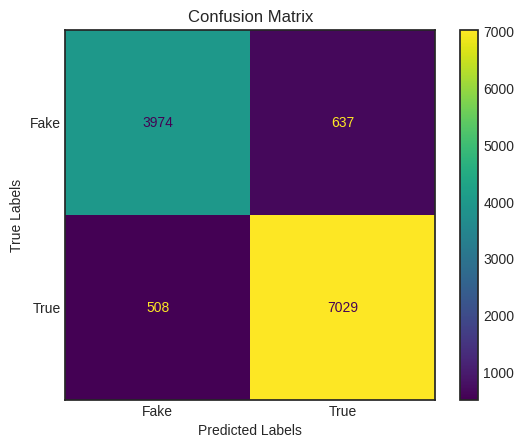

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Round the predicted probabilities to get predicted classes (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display labels
display_labels = ['Fake', 'True']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
plt.gcf().set_size_inches(15, 15)
disp.plot()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9057458017780705

In [41]:
from sklearn.metrics import classification_report

print("Classification Report:\n",classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87      4611
           1       0.92      0.93      0.92      7537

    accuracy                           0.91     12148
   macro avg       0.90      0.90      0.90     12148
weighted avg       0.91      0.91      0.91     12148




<b style="color:#467200">6b. Second Run</b>

<ul style="color:#38629C">
  <li>Number of epochs: 15</li>
  <li>Batch Size: 64</li>
</ul>


In [25]:
# Splitting the final data into X_train, X_test, y_train and y_test for model fitting
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=64)

Epoch 1/15


2023-08-12 10:16:00.163206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 10:16:00.781642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 10:16:02.437924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


760/760 [==============================] - ETA: 0s - loss: 0.2909 - accuracy: 0.8781

2023-08-12 10:25:05.784348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 10:25:05.868147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


760/760 [==============================] - 574s 751ms/step - loss: 0.2909 - accuracy: 0.8781 - val_loss: 0.2175 - val_accuracy: 0.9127
Epoch 2/15
760/760 [==============================] - 2041s 3s/step - loss: 0.2159 - accuracy: 0.9111 - val_loss: 0.2223 - val_accuracy: 0.9089
Epoch 3/15
760/760 [==============================] - 554s 728ms/step - loss: 0.2439 - accuracy: 0.9058 - val_loss: 0.2445 - val_accuracy: 0.9024
Epoch 4/15
760/760 [==============================] - 553s 727ms/step - loss: 0.1906 - accuracy: 0.9223 - val_loss: 0.2224 - val_accuracy: 0.9133
Epoch 5/15
760/760 [==============================] - 563s 740ms/step - loss: 0.2678 - accuracy: 0.8899 - val_loss: 0.3109 - val_accuracy: 0.8676
Epoch 6/15
760/760 [==============================] - 559s 736ms/step - loss: 0.2402 - accuracy: 0.9035 - val_loss: 0.2394 - val_accuracy: 0.9002
Epoch 7/15
760/760 [==============================] - 554s 729ms/step - loss: 0.1828 - accuracy: 0.9273 - val_loss: 0.2459 - val_accuracy

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting from test data
y_pred=model.predict(X_test)

2023-08-12 13:02:07.746390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 13:02:07.944695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


380/380 [==============================] - 47s 123ms/step


<Figure size 1500x1500 with 0 Axes>

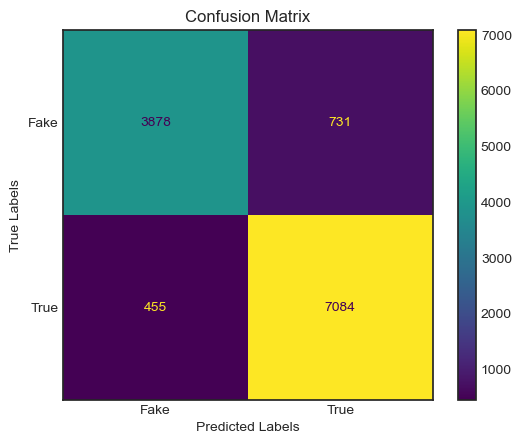

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Round the predicted probabilities to get predicted classes (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display labels
display_labels = ['Fake', 'True']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
plt.gcf().set_size_inches(15, 15)
disp.plot()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.902370760619032

In [29]:
from sklearn.metrics import classification_report

print("Classification Report:\n",classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87      4609
           1       0.91      0.94      0.92      7539

    accuracy                           0.90     12148
   macro avg       0.90      0.89      0.90     12148
weighted avg       0.90      0.90      0.90     12148




<b style="color:#467200">6c. Third Run</b>

<ul style="color:#38629C">
  <li>Number of epochs: 10</li>
  <li>Batch Size: 32</li>
</ul>


In [15]:
# Fitting with 10 epochs and 32 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=32)

Epoch 1/10


2023-08-12 20:01:53.113590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 20:01:53.336692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 20:01:53.786126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1519/1519 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.8895

2023-08-12 20:15:09.107075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 20:15:09.191840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1519/1519 [==============================] - 843s 554ms/step - loss: 0.2636 - accuracy: 0.8895 - val_loss: 0.2377 - val_accuracy: 0.9055
Epoch 2/10
1519/1519 [==============================] - 833s 549ms/step - loss: 0.1848 - accuracy: 0.9235 - val_loss: 0.1939 - val_accuracy: 0.9226
Epoch 3/10
1519/1519 [==============================] - 828s 545ms/step - loss: 0.1703 - accuracy: 0.9309 - val_loss: 0.2005 - val_accuracy: 0.9187
Epoch 4/10
1519/1519 [==============================] - 823s 542ms/step - loss: 0.1664 - accuracy: 0.9324 - val_loss: 0.2201 - val_accuracy: 0.9096
Epoch 5/10
1519/1519 [==============================] - 824s 543ms/step - loss: 0.1364 - accuracy: 0.9458 - val_loss: 0.2197 - val_accuracy: 0.9160
Epoch 6/10
1519/1519 [==============================] - 835s 550ms/step - loss: 0.1193 - accuracy: 0.9526 - val_loss: 0.2136 - val_accuracy: 0.9209
Epoch 7/10
1519/1519 [==============================] - 833s 548ms/step - loss: 0.0949 - accuracy: 0.9626 - val_loss: 0.226

In [39]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
#save the tensorflow model
model.save('LSTM_model.keras')

In [18]:
# Predicting from test data
y_pred=model.predict(X_test)

2023-08-12 22:21:06.188486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 22:21:06.401340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


380/380 [==============================] - 47s 122ms/step


<Figure size 1500x1500 with 0 Axes>

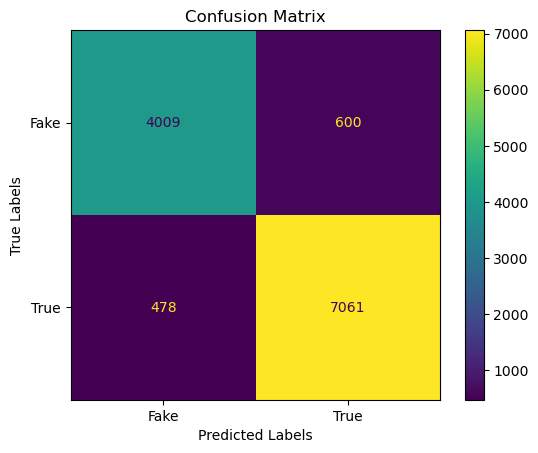

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Round the predicted probabilities to get predicted classes (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display labels
display_labels = ['Fake', 'True']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
plt.gcf().set_size_inches(15, 15)
disp.plot()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [31]:
#Checking the accuracy of the model on the test set
print("LSTM accuracy(%):", accuracy_score(y_test, y_pred)*100)

LSTM accuracy(%): 91.12611129404017


In [32]:
print("LSTM Classification Report:\n",classification_report(y_test, y_pred))

LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4609
           1       0.92      0.94      0.93      7539

    accuracy                           0.91     12148
   macro avg       0.91      0.90      0.91     12148
weighted avg       0.91      0.91      0.91     12148




<b style="color:#467200">7. LSTM-CNN Hybrid Model</b>
<p style="color:#38629C"> This is a hybrid model that combines both LSTM (Long Short-Term Memory) and CNN (Convlu) approaches.  This will involve loading the best performing LSTM model (6c) loading from the Models [named: LSTM_model] and will involve the following steps:<p/>
<ul style="color:#38629C">
  <li> Features extraction from the LSTM model's hidden layers. </li>
  <li> Features extracted from the LSTM model as input to an SVM classifier.</li>
  <li> Train and evaluate the SVM model on the features extracted from the LSTM model.</li>
</ul>


In [60]:
# Number of Dimensions for the word embeddings
embedding_vector_features=40

# LSTM-CNN hybrid model
model_hybrid = Sequential()

# Embedding Layer
model_hybrid.add(Embedding(input_dim=voc_size, output_dim=embedding_vector_features, input_length=sent_length))

# LSTM Layer
model_hybrid.add(LSTM(100, return_sequences=True))

# 1D Convolutional layer with 128 filters and a kernel size of 5
model_hybrid.add(Conv1D(128, 5, activation='relu'))

# Max Pooling to reduce the dimensionality
model_hybrid.add(MaxPooling1D(pool_size=2))

# Hidden Layers
model_hybrid.add(Dense(64, activation='relu'))
model_hybrid.add(Dropout(0.3))
model_hybrid.add(Flatten())
model_hybrid.add(Dropout(0.3))
model_hybrid.add(Dense(32, activation='relu'))
model_hybrid.add(Dropout(0.3))

# Output Layer for binary classification
model_hybrid.add(Dense(1, activation='sigmoid'))

# Compile the model
model_hybrid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
print(model_hybrid.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 5000, 40)          280000    
                                                                 
 lstm_5 (LSTM)               (None, 5000, 100)         56400     
                                                                 
 conv1d_3 (Conv1D)           (None, 4996, 128)         64128     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 2498, 128)         0         
 g1D)                                                            
                                                                 
 dense_8 (Dense)             (None, 2498, 64)          8256      
                                                                 
 dropout_9 (Dropout)         (None, 2498, 64)          0         
                                                      

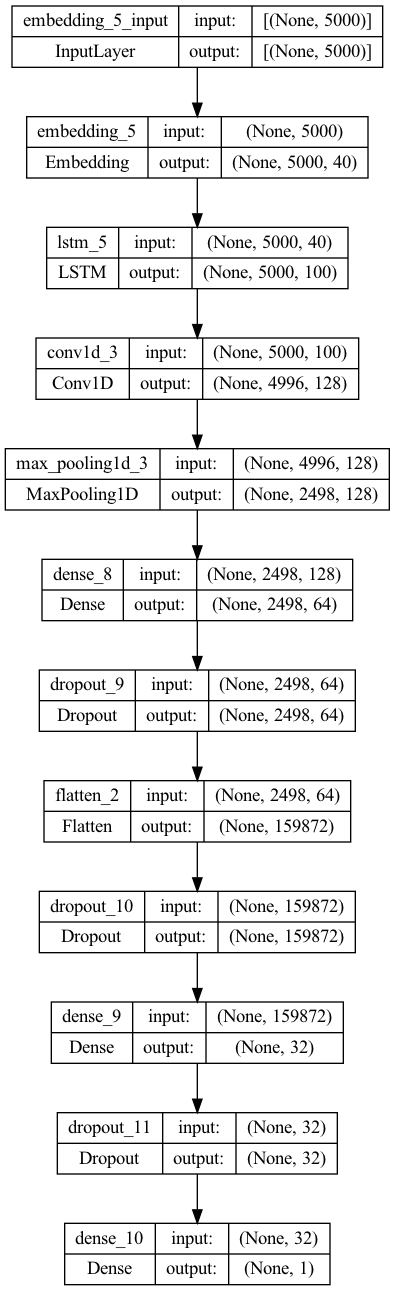

In [61]:
plot_model(model_hybrid, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [65]:
# Fitting with 10 epochs and 32 batch size
training_info = model_hybrid.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=32)

Epoch 1/10


2023-09-15 20:21:31.473968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-15 20:21:31.910893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-15 20:21:35.698699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  47/1519 [..............................] - ETA: 42:13 - loss: 0.9078 - accuracy: 0.5199

KeyboardInterrupt: 

<p style=color:#38629C> <b style=color:#467200 >Conclusion :</b> LSTM model training is completed in this notebook [Part 2] having three different runs (6a,6b,6c) to attain best results, Multinomial Naive Bayes was best performing model among traditional approaches and  attained higher accuracy, precision and recall score in classifying the Fake news. Comparison between LSTM and Naive Bayes is provided in table below</p>

|Model | Run    | Number of epochs | Batch size | Accuracy|Precision    | Recall | F1-Score |
| -----------| ----------- | ----------- |----------- |----------- |-----------|------------|----------- |
| Multinomial Naive Bayes  | -  | -  | -  | 0.90  | 0.93   | 0.79   | 0.86   |
| LSTM | 6a  | 10  | 64   | 0.91  | 0.89  | 0.86   | 0.87  |
| LSTM | 6b  | 15 | 64   | 0.90  | 0.89  | 0.84   | 0.87  |
| LSTM | 6c  | 10 | 32   | 0.91  | 0.89  | 0.87   | 0.88  |

<p style=color:#38629C>LSTM has consistently outperformed in its each run against Naive Bayes (Best Performing Traditional Model) from accuracy, recall and F1-score perspective, however, Naive bayes was slightly better in precision. Though, selecting a model is highly dependent on the task in hand, both recall and precision are important to consider in fake news classification. Since, LSTM's are complex and capable of learning from the context of data. Therefore, it could be good choice to adopt. LSTM based model could be further improved to have optimal precision and recall balance by doing further runs using different hyperparameters or even going further by implementing <u>bidirectional LSTM model training</u>.</p>

<b style=color:#467200 >Next Step :</b> `LSTM` is performing well specifically in comparison to `Multinomial Naive Bayes` and among all traditional machine learning  for classification of `real` and `fake` news. Since, Deep neural learning is capable of handling such complex task, therefore, next step will be to check the `LSTM` against the `LLM - Large Language Model` as it might outperform LSTM as well. There are some other benefit too that could be make comparing both models interesting such as.

*   LLM are trained on much larger dataset which makes them capable of learning complex linguistics patterns.
*   LLM are based on transformer based architecture like BERT which makes them capable of handling long range dependencies better than RNN based models like LSTM.
*   LLM's are capable of handling more wider task apart from classification problems like summarization, question answering etc. So it would be interesting to see how they perform on this news classification task in comparison to LSTM which is focused only on classification.

There are two possible way of using LLM based on zero or few shot classifiers and fine-tuning LLM by locking the base parameters. The brief for both types of approaches is as follows:

1. Zero/Few Shot Classifier: In this approach, LLM models like BERT, GPT-3 etc can be directly used for classification without without any or with very few examples to frame the classification problem as task where model predicts the missing class label. For example, a LLM can be given an instruction like “classify this sentence/context as `real` and `fake` news” and then a it will be classified, without having seen any labeled data for classification analysis before. This approach relies on the power of LLM's linguistic understanding, requires very less data and computational resources but performance may not be at par with fine-tuned models. The performance though varies depending on the model parameters (i.e. GPT-3 vs BERT or BERT 1B, 7B,etc) and the complexity of task.

2. Fine-tuning LLM: In this approach, the base parameters of LLM are locked while additional classification layers are added on top and trained on labeled news classification data while keeping rest of the model fixed. This allows LLM to leverage its pre-trained knowledge while adapting to the downstream task. However, It requires labeled data but usually outperforms zero/few shot approach. The fine-tuning can be done for few epochs to avoid catastrophic forgetting of pre-trained knowledge or progressively fine-tuned to leverage both pre-trained and task specific knowledge. This provides a good balance of data efficiency and performance for complex tasks by preserving the core linguistic knowledge of LLM, while adopting to the classification task. There is disadvantage too that it may not achieve the optimal performance as some of the based parameters are may not be optimal for the new task.


The next notebook named as `Final Project - Part 3 (LLM Zero-Few Shot)`  saved in the same directory will be used for Zero and Few shot classifiers using LLM models BERT and compare their performance with LSTM. Separate notebook is created because the model was trained and testing on Google Colab for BERT due to its large size.

<i style=color:#38629C>Final-Project/Notebooks/Final Project - Part 3 (LLM Zero-Few Shot).ipynb</i>